## Implementing K-Means Clustering

This is my simple implementation of a *K-Means Clustering* algorithm, foregoing *Within Cluster Sum of Squares* and the *Elbow Rule*

*K-Means* is a clustering algorithm that groups data as specified by the user (number of clusters, k). It assigns data points to the closest cluster based on the calculated distances.

Here are the general steps:
- Generate random centroids
- Calculate the distance of each datapoint to each centroid
- Assign each datapoint to the centroid it's closest to
- Recalculate the centroids as the mean of all datapoints assigned to a cluster
- Repeat the cluster assignment and update until the algorithm converges

In [2]:
from fastkaggle import get_dataset
from pathlib import Path
from fastai.tabular.all import *

## Dataset

My first attempt at a clustering algorithm was a botched attempt at a DBSCAN from scratch. I wanted to use a dataset that was clearly segmented visually for ease of tracking what was happening. I haven't quite worked out the kinks in the DBSCAN notebook yet, but I don't see any harm in using it for k-means as well.

The data we're going to target is the *spending score* as it relates to *annual income*

In [3]:
path = Path('data/dbscan')
dataset = 'vjchoudhary7/customer-segmentation-tutorial-in-python'
if not path.exists():
    data = get_dataset(path, dataset, unzip=True)
df = pd.read_csv(path/'Mall_Customers.csv', low_memory=False)

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Plotting the Target Datapoints

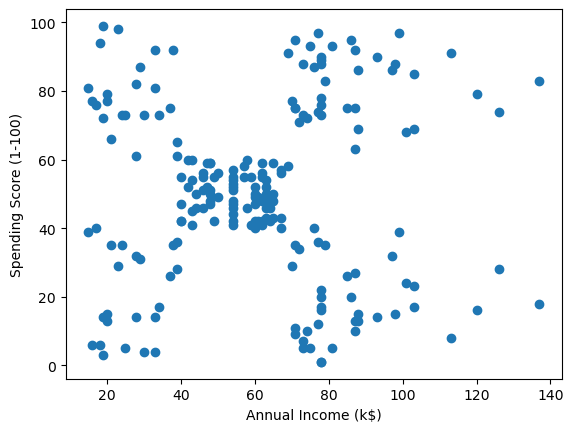

In [6]:
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
plt.scatter(x,y)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

Convert the pandas dataframe to a pytorch tensor to utilize the GPU

In [7]:
x_y_tens = torch.from_numpy(df.to_numpy()[:,3:].astype(float)).to("cuda")

## Picking *k* Centroids

First, a random set of centroids is generated. This is the starting point for our clustering process. The centroids are the central points of our clusters. In this implementation, the number of centroids is chosen by a pretty clear visual grouping pattern in the data

In [8]:
k = 5

Next, we randomly pick those *k* random points as the initial cluster centroids

In [9]:
sample_idxs = torch.randperm(x_y_tens.shape[0])[:5]
centroids = x_y_tens[sample_idxs]
centroids

tensor([[88., 69.],
        [78., 16.],
        [20., 79.],
        [78., 88.],
        [72., 34.]], device='cuda:0', dtype=torch.float64)

Here I'm just cloning the original centroids to use in a later animation

In [10]:
og_centroids = centroids.clone()

Detaching the tensors to numpy to plot gets pretty tedious, so here I'm creating a function to lighten the load just a bit.

In [11]:
def np_detach(tens):
    return tens.detach().cpu().numpy()

Plotting the initial data with centroids marked

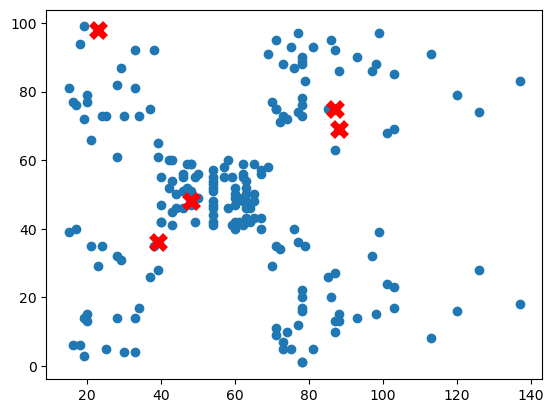

In [12]:
x = np_detach(x_y_tens)[:,0]
y = np_detach(x_y_tens)[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)
for cen in centroids:
    ax.plot(np_detach(cen)[0], np_detach(cen)[1], markersize=10, marker="x", color='r', mew=5)
    

In [14]:
x_y_tens[0]

tensor([15., 39.], device='cuda:0', dtype=torch.float64)

In [15]:
x_y_tens.shape, centroids.shape

(torch.Size([200, 2]), torch.Size([5, 2]))

To calculate the Euclidean distance between two matrices A and B using the Frobenius norm, you first subtract one matrix from the other element-wise to obtain a matrix C, where C(i,j) = A(i,j) - B(i,j). Then, you compute the Frobenius norm of matrix C:

dist = ||C||F

This distance metric quantifies the dissimilarity between the two matrices in terms of the overall magnitude of their differences. The smaller the distance, the more similar the matrices are in terms of their element values.

It's worth noting that when working with vectors (1-dimensional matrices), the Frobenius norm reduces to the usual Euclidean norm.

In [16]:
(x_y_tens.unsqueeze(1) - centroids.unsqueeze(0)).shape

torch.Size([200, 5, 2])

In [17]:
(x_y_tens.unsqueeze(1) - centroids.unsqueeze(0))[-1]

tensor([[ 89.,  35.],
        [ 98.,  47.],
        [ 49.,  14.],
        [ 50.,   8.],
        [114., -15.]], device='cuda:0', dtype=torch.float64)

## Calculate the Frobenius norm

In [18]:
def euclidean_dist(a, b):
    return torch.norm(a-b, dim=-1)

Get the initial distance of each point to its nearest cluster

In [19]:
distances = euclidean_dist(x_y_tens.unsqueeze(1), centroids.unsqueeze(0))

Assign each point to its nearest cluster centroid

In [20]:
cluster_assignments = torch.argmin(distances, dim=1)

In [21]:
og_cluster_assignments = cluster_assignments.clone()

Plotting initial cluster assignments

In [22]:
def plot_clusters(data, centroids, assignments):
    plt.clf()
    data, centroids, assignments = np_detach(data), np_detach(centroids), np_detach(assignments)
    plt.scatter(data[:,0], data[:,1], c=assignments, s=30)
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', color='red', s=60)

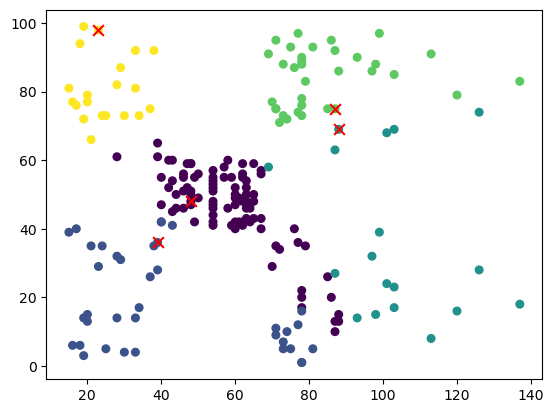

In [23]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

In [24]:
def assign_to_nearest_centroid(data, centroids):
    distances = euclidean_dist(data.unsqueeze(1), centroids.unsqueeze(0))
    cluster_assignments = torch.argmin(distances, dim=1)
    return cluster_assignments

In [25]:
cluster_assignments

tensor([1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
        1, 4, 1, 0, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3,
        1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 0, 3, 0, 3,
        2, 2, 0, 3, 0, 3, 0, 3, 0, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2,
        2, 3, 2, 3, 2, 2, 2, 3], device='cuda:0')

In [26]:
new_centroids = torch.zeros_like(centroids)
new_centroids

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', dtype=torch.float64)

In [27]:
test_count = 0
for i in range(centroids.shape[0]):
    assigned_points = x_y_tens[cluster_assignments == i]
    test_count += assigned_points.shape[0]
test_count

200

In [28]:
centroids

tensor([[48., 48.],
        [39., 36.],
        [88., 69.],
        [87., 75.],
        [23., 98.]], device='cuda:0', dtype=torch.float64)

Calculate the centroids of the newly formed clusters

In [29]:
def update_centroids(data, cluster_assignments, centroids): 
    new_centroids = torch.zeros_like(centroids)
    for i in range(centroids.shape[0]):
        assigned_points = data[cluster_assignments == i]
        if len(assigned_points) > 0:
            new_centroids[i] = torch.mean(assigned_points, dim=0)
    return new_centroids

A single centroid update

In [30]:
new_centroids = update_centroids(x_y_tens, cluster_assignments, centroids)

Plotting our single centroid update

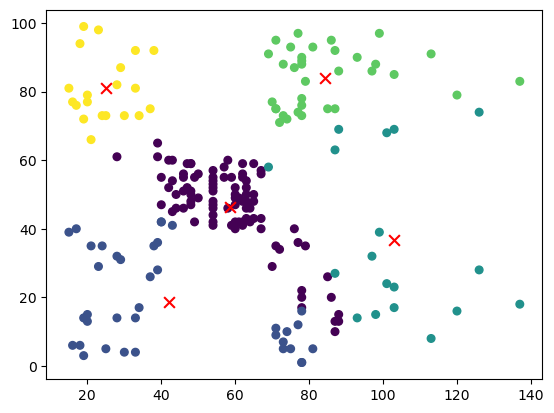

In [31]:
plot_clusters(x_y_tens, new_centroids, cluster_assignments)

Repeating the cluster assignment and centroid updates for several iterations

In [32]:
def k_means(data, centroids, iterations=10):
    for i in range(iterations):
        cluster_assignments = assign_to_nearest_centroid(data, centroids)
        new_centroids = update_centroids(data, cluster_assignments, centroids)
    cluster_assignments = assign_to_nearest_centroid(data, centroids)
    return cluster_assignments, new_centroids

In [33]:
cluster_assignments, centroids = k_means(x_y_tens, centroids)

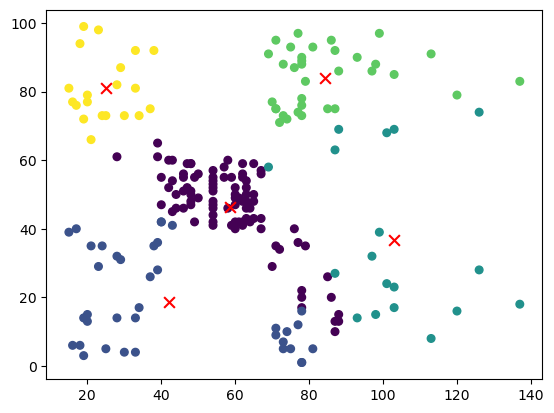

In [34]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

Starting from scratch to make an animation

In [35]:
centroids = og_centroids
cluster_assignments = og_cluster_assignments

In [36]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

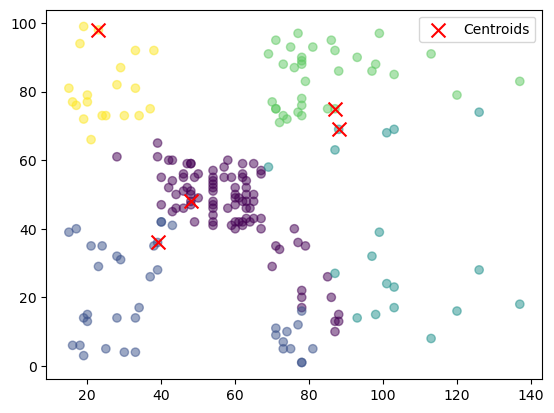

In [37]:
fig, ax = plt.subplots()

# Set up the initial plot
scatter = ax.scatter(np_detach(x_y_tens[:, 0]), np_detach(x_y_tens[:, 1]), c=np_detach(cluster_assignments), cmap='viridis', alpha=0.5)
centroid_plot = ax.scatter(np_detach(centroids[:, 0]), np_detach(centroids[:, 1]), c='red', marker='x', s=100, label='Centroids')
ax.legend()

In [38]:
def init():
    return scatter, centroid_plot

In [39]:
def update(frame):
    global x_y_tens, centroids, cluster_assignments
    
    # Step 1: Assign x_y_tens points to the nearest centroid
    cluster_assignments = assign_to_nearest_centroid(x_y_tens, centroids)

    # Step 2: Update centroids
    updated_centroids = update_centroids(x_y_tens, cluster_assignments, centroids)

    # Update plot
    scatter.set_array(np_detach(cluster_assignments))
    centroid_plot.set_offsets(np_detach(updated_centroids))
    centroids = updated_centroids
    
    return scatter, centroid_plot

In [40]:
ani = FuncAnimation(fig, update, frames=10, init_func=init, blit=True, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [41]:
%timeit -n 10 k_means(x_y_tens, centroids)

13 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
